# 환경설정

### 패키지 설치 및 임포트

In [ ]:
# !pip install torch
# !pip install torchvision


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [1]:
import matplotlib.pyplot as plt # 시각화를 위한 라이브러리

import torch # PyTorch 라이브러리
import torch.nn as nn # 모델 구성을 위한 라이브러리
from torch.utils.data import DataLoader # optimizer 설정을 위한 라이브러리

import torchvision # PyTorch의 컴퓨터 비전 라이브러리
import torchvision.transforms as T # 이미지 변환을 위한 모듈
import torchvision.utils as vutils # 이미지를 쉽게 처리하기 위한 유틸리티 모듈

In [2]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

#머신러닝 실험에서 동일한 조건 하에 여러 번 실행해도 동일한 결과를 얻을 수 있도록 합니다.
def random_seed(seed_num):
    torch.manual_seed(seed_num)   #yTorch의 CPU 연산에서 무작위성을 제어하는 시드 값을 설정
    torch.cuda.manual_seed(seed_num)   #PyTorch의 GPU 연산에서 무작위성을 제어하는 시드 값을 설정
    torch.cuda.manual_seed_all(seed_num)   #PyTorch의 모든 GPU 장치에서 무작위성을 제어하는 시드 값을 설정
    cudnn.benchmark = False   #CuDNN의 벤치마크 기능을 비활성화. 입력 데이터 크기에 따라 최적의 알고리즘을 선택하는 기능으로, 비활성화하여 실행의 일관성을 유지
    cudnn.deterministic = True   #CuDNN을 결정론적으로 설정. 동일한 입력에 대해 항상 동일한 결과를 얻을 수 있음
    random.seed(seed_num)   #Python의 기본 난수 생성기의 시드 값을 설정

random_seed(42)

# 1.데이터

## 1-1 torchvision 라이브러리를 사용하여 구현된 Dataset 불러오기

### torchvision의 datasets 모듈
`torchvision.datasets`를 사용하면 다양한 비전 Dataset을 불러올 수 있습니다. 그 중에서 MNIST Dataset을 불러와 실습해보도록 하겠습니다.
MNIST Dataset 외에도 CIFAR10, CIFAR100, ImageNet 등 Dataset들도 편리하게 불러올 수 있습니다.

- `torchvision.datasets.CIFAR10`
- `torchvision.datasets.CIFAR100`
- `torchvision.datasets.ImageNet`
- ..

* [torchvision.datasets - PyTorch 공식 문서](https://pytorch.org/vision/stable/datasets.html): 소개한 Dataset 이 외에도 다양한 Dataset이 존재합니다. '좌측 링크'에서 불러올 수 있는 Dataset을 확인할 수 있습니다.
* [torch.utils.data.random_split - PyTorch 공식 문서](https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split)

아래 코드의 전체적인 역할은 MNIST 데이터셋의 이미지를 텐서로 변환하는 것입니다. 이는 딥러닝 모델이 이미지를 처리할 수 있는 형식으로 변환하는 필수적인 단계입니다. MNIST 데이터셋은 일반적으로 흑백 이미지로 구성되어 있으며, 각 이미지의 크기는 28x28 픽셀입니다. T.ToTensor() 변환을 통해 각 이미지가 크기 (1, 28, 28)인 텐서로 변환됩니다.

In [3]:
# MNIST 데이터셋의 이미지를 전처리하기 위해 PyTorch의 torchvision.transforms 모듈을 사용하여 일련의 변환(transformations)을 정의
# 데이터를 불러올 때, 필요한 변환(transform)을 정의.
# T.Compose를 사용하여 여러 변환을 순차적으로 적용하는 파이프라인을 만듦
# T는 torchvision.transforms 모듈을 import torchvision.transforms as T와 같이 줄여서 사용한 것

## T.Compose([...]): 여러 변환을 순차적으로 적용할 수 있도록 변환 리스트를 묶어줍니다. 리스트 안에 있는 변환들은 주어진 순서대로 이미지를 변환합니다.
## T.ToTensor(): 이미지를 PyTorch 텐서(tensor) 형식으로 변환합니다. 이 변환은 다음과 같은 작업을 수행합니다:
    ### 이미지를 [0, 255] 범위의 픽셀 값에서 [0, 1] 범위의 부동 소수점(float) 값으로 정규화합니다.
    ### 이미지의 형태를 (높이, 너비, 채널)에서 (채널, 높이, 너비)로 변경합니다. PyTorch에서는 이 순서로 텐서를 다룹니다.
mnist_transform = T.Compose([
    T.ToTensor(), # 텐서 형식으로 변환
])

아래 코드를 실행하면 MNIST 데이터셋이 지정된 경로(./MNIST_DATASET)에 다운로드되고, 각각 학습용과 테스트용으로 나뉘어 로드됩니다. 또한, 각 데이터셋의 이미지들은 앞서 정의한 mnist_transform을 통해 텐서 형식으로 변환됩니다. 이를 통해 데이터가 딥러닝 모델에 입력될 수 있는 형식으로 준비됩니다.

In [4]:
# torchvision 라이브러리를 사용하여 MNIST Dataset을 불러옵니다.
# MNIST 데이터셋이 저장될 경로를 지정합니다. 이 경로에 데이터셋이 다운로드되고 저장됩니다.
download_root = './MNIST_DATASET'

# torchvision.datasets.MNIST 클래스를 사용하여 학습(train) 데이터셋을 다운로드하고 로드합니다.
# download_root는 데이터셋이 저장될 경로를 지정합니다.
# transform=mnist_transform는 앞서 정의한 변환 파이프라인을 적용합니다. 이 경우, 이미지를 텐서 형식으로 변환합니다.
# train=True는 학습용 데이터셋을 로드하도록 지정합니다.
# download=True는 데이터셋이 지정된 경로에 없을 경우 다운로드하도록 지정합니다.
train_dataset = torchvision.datasets.MNIST(download_root, transform=mnist_transform, train=True, download=True) # train dataset 다운로드
# 위와 동일한 방식으로 테스트(test) 데이터셋을 다운로드하고 로드합니다.
# train=False는 테스트용 데이터셋을 로드하도록 지정합니다.
test_dataset = torchvision.datasets.MNIST(download_root, transform=mnist_transform, train=False, download=True) # test dataset 다운로드

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15829809.05it/s]


Extracting ./MNIST_DATASET/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 490948.67it/s]


Extracting ./MNIST_DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4364062.55it/s]


Extracting ./MNIST_DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST_DATASET/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2422498.57it/s]

Extracting ./MNIST_DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_DATASET/MNIST/raw



아래 코드를 실행하면 train_dataset에서 첫 번째 이미지와 해당 레이블이 출력됩니다. 예를 들어, 출력 결과가 (torch.Size([1, 28, 28]), 5)라면, 첫 번째 이미지의 형태는 [1, 28, 28]이고, 해당 이미지의 레이블은 5임을 의미합니다.

이 코드를 통해 train_dataset에서 이미지의 형태가 올바르게 변환되었는지, 그리고 레이블이 제대로 로드되었는지 확인할 수 있습니다.

In [5]:
# train_dataset에서 하나씩 이미지와 레이블을 가져옴.
    ## train_dataset은 torchvision.datasets.MNIST 클래스의 인스턴스로, 이미지와 레이블의 쌍으로 구성된 데이터셋.
# image는 하나의 MNIST 이미지에 해당하며, label은 해당 이미지의 숫자 레이블(0-9)을 나타냄
for image, label in train_dataset:
    # image의 형태(shape)와 label을 출력.
    # image.shape는 이미지 텐서의 형태를 나타내며, MNIST 데이터셋의 경우 [C, H, W] 형식. C는 채널 수, H는 높이(height), W는 너비(width)
    # MNIST 데이터셋은 흑백 이미지이므로 채널 수 C = 1, 이미지의 높이 H = 28, 너비 W = 28 따라서 출력되는 형태는 [1, 28, 28]
  print(image.shape, label)
  break   # 반복문을 종료. train_dataset에서 첫 번째 이미지와 레이블만 출력되고 반복문이 종료

torch.Size([1, 28, 28]) 5


아래 코드를 실행하면 전체 학습 데이터셋이 80%는 학습 데이터셋으로, 20%는 검증 데이터셋으로 분리됩니다. 이는 모델 학습 과정에서 검증 데이터셋을 사용하여 모델의 성능을 평가하고 과적합(overfitting)을 방지하는 데 유용합니다.

In [6]:
# 데이터 셋을 학습 데이터 셋과 검증 데이터 셋으로 분리합니다.

# train_dataset의 총 데이터 개수를 total_size 변수에 저장
total_size = len(train_dataset)
# 학습 데이터셋과 검증 데이터셋의 개수를 계산
train_num, valid_num = int(total_size * 0.8), int(total_size * 0.2) # 8 : 2 = train : valid
print("Train dataset 개수 : ",train_num)
print("Validation dataset 개수 : ",valid_num)
# torch.utils.data.random_split 함수를 사용하여 train_dataset을 학습 데이터셋과 검증 데이터셋으로 무작위로 분할
# train_num과 valid_num은 각 데이터셋의 크기를 지정
# train_dataset과 valid_dataset은 각각 학습 데이터셋과 검증 데이터셋을 나타내는 새로운 데이터셋 객체로 반환
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num]) # train - valid set 나누기

Train dataset 개수 :  48000
Validation dataset 개수 :  12000


## 1-2 불러온 Dataset을 사용하여 DataLoader 정의하기

> `DataLoader`는 인자로 주어진 `Dataset`을 이용하여, 단일 데이터들을 정해진 개수만큼 모아 미니 배치(mini-batch)를 구성하는 역할을 합니다. `torch.utils.data` 라이브러리를 사용하여 편리하게 DataLoader를 구현할 수 있습니다.

### PyTorch DataLoader의 인자
`torchvision.datasets`를 통해 불러온 `Dataset`을 `DataLoader`의 인자로 필수로 넘겨줘야 합니다. 이 외에도 `DataLoader`에는 추가 인자들이 존재합니다.

- `batch_size`: 미니 배치의 크기를 나타냅니다. 별도의 선언이 없을 경우, 1로 지정됩니다.
- `shuffle`: epoch마다 데이터의 순서가 섞이는 여부를 나타냅니다. 학습에 사용하는 데이터로더의 경우에는 모델이 학습 데이터의 순서에 의존하지 않도록 하기위해 셔플을 진행합니다.
- `num_workers`: 데이터 로딩에 사용하는 서브 프로세스 개수를 나타냅니다.
- `drop_last`: 마지막 미니 배치의 데이터 수가 미니 배치 크기보다 작은 경우, 데이터를 버릴지 말지를 나타냅니다.
- `pin_memory`: PyTorch의 DataLoader에서 GPU를 사용하는 경우 데이터 로딩 속도를 높이는 옵션입니다. `pin_memory=True`를 설정하면, DataLoader는 데이터를 CUDA 고정 메모리(CUDA pinned memory)에 로드하여 CPU 메모리에서 GPU 메모리로 데이터를 더 빠르게 전송할 수 있습니다.
- ..

* [torch.utils.data.DataLoader - PyTorch 공식 문서](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): 소개한 인자 외에도 추가적인 인자들이 존재합니다.
* [pin_memory 옵션](https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/): 해당 내용은 운영 체제의 가상 메모리(virtual memory)와 스와핑(swapping) 개념을 이해한 후, 살펴보면 좋습니다.

아래 코드는 학습, 검증, 테스트 데이터셋을 각각 배치 단위로 로드할 수 있는 데이터 로더를 생성합니다. 학습 데이터는 무작위로 섞어서 모델이 데이터 순서에 의존하지 않도록 하고, 검증 및 테스트 데이터는 순서를 유지하여 모델 평가에 사용합니다.

In [7]:
# 한 번에 처리할 데이터의 개수를 32로 설정. 즉, 각 배치(batch)는 32개의 데이터를 포함.
batch_size = 32

# 학습용 데이터 로더를 생성
# 앞서 선언한 Dataset을 인자로 주어 DataLoader를 선언합니다.
# shuffle = True는 학습 데이터셋을 매 에포크(epoch)마다 무작위로 섞도록 설정. 학습 과정에서 모델이 데이터 순서에 의존하지 않도록 도와줌.
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
# 검증용 데이터 로더를 생성
# shuffle = False는 검증 데이터셋을 섞지 않고 순서대로 로드. 검증 데이터는 모델 평가에 사용되므로, 순서를 유지하는 것이 일반적
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)
# 테스트용 데이터 로더를 생성
# shuffle = False는 테스트 데이터셋을 섞지 않고 순서대로 로드. 테스트 데이터도 모델의 최종 성능 평가에 사용되므로, 순서를 유지하는 것이 일반적
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

아래 코드를 통해 데이터 로더가 배치 단위로 데이터를 올바르게 로드하고 있는지 확인할 수 있습니다. 특히, 이미지와 레이블의 형태가 예상대로 맞는지 확인하는 데 유용합니다.

In [8]:
# 학습 데이터 로더(train_dataloader)에서 첫 번째 미니 배치(mini-batch) 데이터를 가져와서 그 형태(shape)를 출력하는 역할
    ## train_dataloader에서 배치 단위로 이미지와 레이블을 가져옵니다.
    ## images는 한 배치에 포함된 여러 이미지들을 나타내며, labels는 해당 이미지들에 대한 레이블을 나타냅니다.
for images, labels in train_dataloader:
  # images.shape는 이미지 배치의 형태를 나타내고, labels.shape는 레이블 배치의 형태를 나타냅니다.
  print(images.shape, labels.shape)
  # 반복문을 종료. train_dataloader에서 첫 번째 미니 배치만 가져와서 출력하고 반복문 종료
  break

torch.Size([32, 1, 28, 28]) torch.Size([32])


* images.shape는 [32, 1, 28, 28]
    - 첫 번째 차원(32)은 배치 크기. 즉, 한 배치에 32개의 이미지.
    - 두 번째 차원(1)은 채널 수. MNIST 데이터셋은 흑백 이미지이므로 채널 수는 1.
    - 세 번째와 네 번째 차원(28, 28)은 각각 이미지의 높이와 너비.
* labels.shape는 [32]
    - 이 차원은 배치 크기를 나타냄. 즉, 32개의 이미지에 대한 레이블이 있음.

아래 코드는 학습 데이터로더에서 가져온 이미지 배치를 격자 형태로 시각화하여 확인할 수 있도록 합니다. 이는 데이터가 올바르게 로드되었는지, 이미지가 제대로 변환되었는지 시각적으로 검토하는 데 유용합니다.

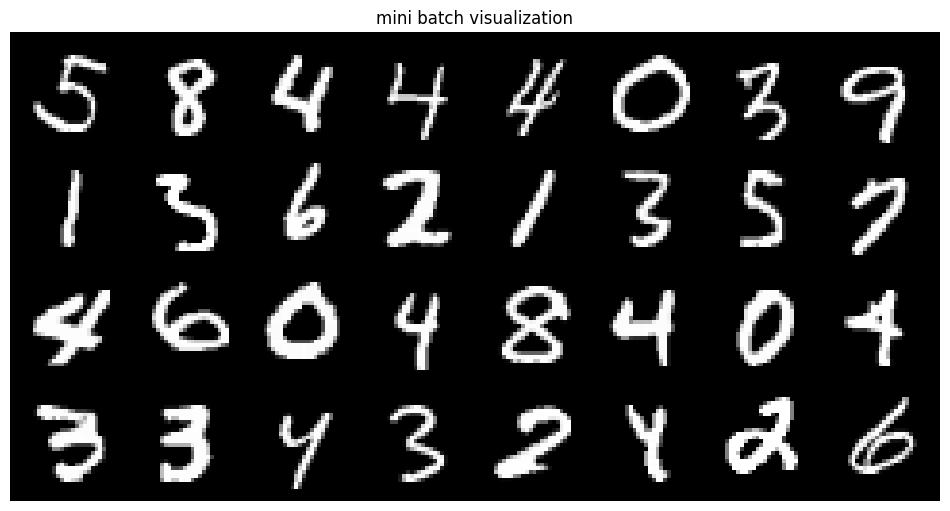

In [9]:
# vutils는 torchvision.utils 모듈을 줄여서 사용한 것
# make_grid 함수는 여러 이미지를 격자(grid) 형태로 배치하여 하나의 이미지로 만듦
# images는 train_dataloader에서 가져온 이미지 배치
# nrow=8은 각 행에 8개의 이미지를 배치하도록 설정. 배치 크기가 32인 경우 4행 8열의 격자로 구성
grid = vutils.make_grid(images, nrow=8)

# 학습 데이터로더로 부터 불러온 이미지를 시각화합니다
plt.figure(figsize=(12,12))
# plt.imshow 함수는 이미지를 시각화
# grid는 make_grid 함수로 만든 이미지 격자
# grid.numpy()는 PyTorch 텐서를 NumPy 배열로 변환. matplotlib 이 이미지를 시각화하기 위해 NumPy 배열 형식을 필요로 하기 때문.
# .transpose((1,2,0))은 배열의 차원을 변경.
# PyTorch의 이미지 텐서 형식은 [C, H, W] (채널, 높이, 너비)인 반면, matplotlib은 [H, W, C] (높이, 너비, 채널) 형식을 필요로 함.
# 따라서 차원을 [1, 2, 0] 순서로 재배치
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.title("mini batch visualization")
plt.axis('off')
plt.show()

# 2.모델

## 2-1 nn.Module을 사용하여 Custom model 정의

> PyTorch의 `nn.Module`을 상속받아 MNIST 숫자 이미지 데이터를 분류하는 모델을 구현합니다.

### Custom model 정의
MNIST 숫자 이미지 데이터를 분류하는 모델을 구현합니다. 일반적으로 이미지 데이터를 처리하는 모델로 CNN(Convolution Neural Network)을 많이 사용합니다. 이번 실습에서는 CNN을 사용하기 전에 fully connected layers로 구성된 DNN(Deep Neural Network)을 먼저 구현해 봅니다.

MNIST 숫자 이미지 데이터는 28 $\times$ 28 크기를 갖는 2D matrix입니다. DNN의 입력으로 사용하기 위해 matrix를 1차원으로 펼쳐야 합니다. 입력 데이터를 펼치기 위해 `forward`의 첫 연산으로 `x = x.view(x.shape[0], -1)`를 진행합니다.


**참고 사항**

DNN 모델을 설계할 때, 레이어의 개수는 하이퍼 파라미터의 일종입니다. 레이어의 개수는 모델의 복잡성과 관련이 있으며, 레이어를 너무 많이 쌓거나 너무 적게 쌓는 경우 문제가 발생할 수 있습니다.
- **레이어를 너무 깊게 쌓을 경우**: 모델의 복잡성이 증가하여 오버피팅의 위험이 증가할 수 있습니다. 또한 gradient vanishing, exploding의 문제가 발생할 수 있습니다.
-  **레이어를 너무 적게 쌓을 경우**: 모델이 너무 단순하여 학습 데이터의 패턴을 충분히 포착하지 못하는 현상인 언더피팅이 발생할 수 있습니다. 이에 따라 일반화 성능이 제한될 수 있습니다.


**주의 사항**

`nn.Linear`를 통해 레이어를 정의할 때는 입력 데이터의 차원과 레이어의 입력 차원이 일치해야 합니다.

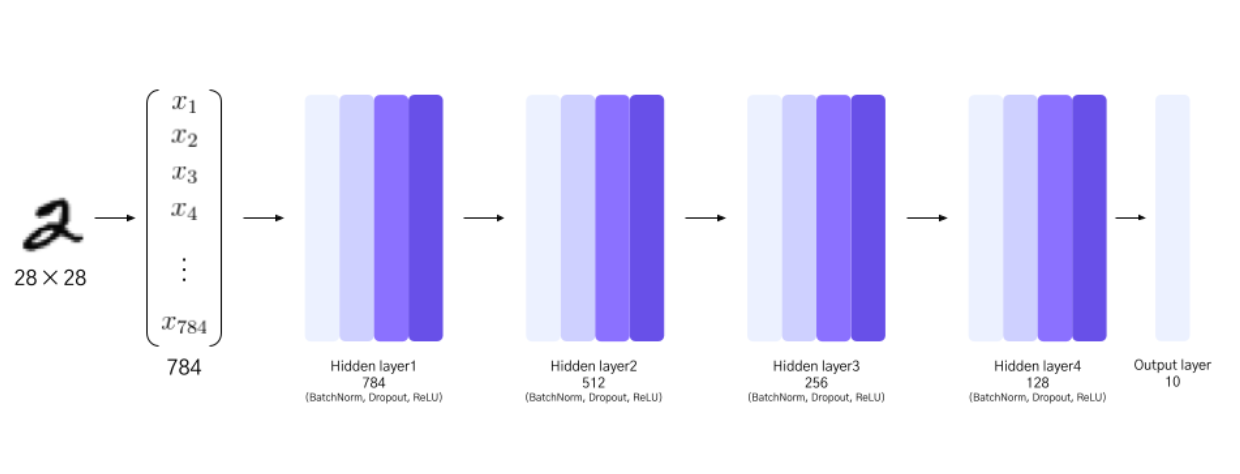

아래 코드는 PyTorch를 사용하여 심층 신경망(DNN)을 정의하는 클래스입니다. 클래스는 여러 옵션에 따라 모델 구조를 설정할 수 있도록 설계되었습니다.  클래스는 유연하게 구성할 수 있는 DNN 모델을 정의하며, 각 레이어와 기능을 사용자가 지정한 대로 활성화하거나 비활성화할 수 있습니다.








* `__init__` : 클래스 초기화 메서드. 여러 매개변수를 받아 모델의 구조를 설정

```
- hidden_dim: 은닉층의 크기를 설정.
- num_classes: 최종 출력 클래스의 수를 설정.
- dropout_ratio: 드롭아웃(dropout) 비율을 설정.
- apply_batchnorm: 배치 정규화(batch normalization) 적용 여부를 설정.
- apply_dropout: 드롭아웃 적용 여부를 설정.
- apply_activation: 활성화 함수 적용 여부를 설정.
- set_super: super().__init__() 호출 여부를 설정.
```



In [12]:
# class DNN(nn.Module): PyTorch의 nn.Module을 상속받아 새로운 신경망 클래스를 정의
# __init__: 클래스 초기화 메서드. 여러 매개변수를 받아 모델의 구조를 설정
class DNN(nn.Module):
  def __init__(self, hidden_dim, num_classes, dropout_ratio, apply_batchnorm, apply_dropout, apply_activation, set_super):
    if set_super:
      super().__init__()
    # Fully connected layer (완전 연결층) 및 기타 레이어 선언.
        ## fc1, fc2, fc3, classifier: 입력을 각각의 크기에 맞는 완전 연결층으로 변환
            ### fc1: 입력을 28 * 28(이미지 크기)에서 hidden_dim * 4로 변환.
            ### fc2: hidden_dim * 4에서 hidden_dim * 2로 변환.
            ### fc3: hidden_dim * 2에서 hidden_dim으로 변환.
            ### classifier: 최종 은닉층 출력인 hidden_dim에서 num_classes로 변환.
    self.fc1 = nn.Linear(28 * 28, hidden_dim * 4)
    self.fc2 = nn.Linear(hidden_dim * 4, hidden_dim * 2)
    self.fc3 = nn.Linear(hidden_dim * 2, hidden_dim)
    self.classifier = nn.Linear(hidden_dim, num_classes)

    # Batch normalization (배치정규화) 선언.
    # apply_batchnorm 인자가 False일 경우, batch normalization은 적용되지 않습니다.
    # apply_batchnorm이 False이면 nn.Identity()를 사용하여 아무 작업도 하지 않습니다.
    self.batchnorm1 = nn.BatchNorm1d(hidden_dim * 4) if apply_batchnorm else nn.Identity()
    self.batchnorm2 = nn.BatchNorm1d(hidden_dim * 2) if apply_batchnorm else nn.Identity()
    self.batchnorm3 = nn.BatchNorm1d(hidden_dim) if apply_batchnorm else nn.Identity()

    # Dropout(드롭아웃) 선언 : dropout1, dropout2, dropout3: 드롭아웃을 적용할지 여부를 설정
    # Dropout은 레이어를 통과한 중간 연산 결과를 dropout_ratio 만큼의 비율로 element를 '0'으로 변경합니다.
    # 학습을 규제하여 일반화 성능을 높이고 싶을 때 사용합니다.
    # Dropout을 선언합니다. apply_dropout 인자가 False일 경우, dropout은 적용되지 않습니다.
    self.dropout1 = nn.Dropout(dropout_ratio) if apply_dropout else nn.Identity()
    self.dropout2 = nn.Dropout(dropout_ratio) if apply_dropout else nn.Identity()
    self.dropout3 = nn.Dropout(dropout_ratio) if apply_dropout else nn.Identity()

    # Activation function (활성화 함수)을 선언합니다.
    # apply_activation 인자가 False일 경우, activation function은 적용되지 않습니다.
    self.activation1 = nn.ReLU() if apply_activation else nn.Identity()
    self.activation2 = nn.ReLU() if apply_activation else nn.Identity()
    self.activation3 = nn.ReLU() if apply_activation else nn.Identity()

    # 소프트맥스 (Softmax) 선언 : 소프트맥스 함수를 사용하여 최종 출력을 확률로 변환
    self.softmax = nn.LogSoftmax(dim = 1)

  # 순전파 (Forward) 정의 메서드 : 입력 x를 각 레이어를 통해 순차적으로 변환
  def forward(self, x):
    """
    Input and Output Summary

    Input:
      x: [batch_size, 1, 28, 28]
    Output:
      output: [batch_size, num_classes]

    """
    # 입력 이미지를 일렬로 펼칩. x의 형태는 [batch_size, 784]
    x = x.view(x.shape[0], -1)  # [batch_size, 784]

    # x = self.fc1(x), x = self.fc2(x), x = self.fc3(x), x = self.classifier(x): 입력을 각 완전 연결층을 통해 변환
    # self.batchnorm1(x), self.batchnorm2(x), self.batchnorm3(x): 배치 정규화를 적용
    # self.activation1(x), self.activation2(x), self.activation3(x): 활성화 함수를 적용
    # self.dropout1(x), self.dropout2(x), self.dropout3(x): 드롭아웃을 적용
    x = self.fc1(x) # [batch_size, dim * 4]
    x = self.batchnorm1(x)
    x = self.activation1(x)
    x = self.dropout1(x)

    x = self.fc2(x) # [batch_size, dim * 2]
    x = self.batchnorm2(x)
    x = self.activation2(x)
    x = self.dropout2(x)

    x = self.fc3(x) # [batch_size, dim]
    x = self.batchnorm3(x)
    x = self.activation3(x)
    x = self.dropout3(x)

    x = self.classifier(x) # [batch_size, 10]
    # output = self.softmax(x): 최종 출력에 소프트맥스를 적용하여 확률로 변환
    output = self.softmax(x)
    return output

> ***위의 코드는 비효율적 - 아래에 위 코드를 단순화해서 다시 모델 정의***

아래 코드는 PyTorch를 사용하여 심층 신경망(DNN)을 정의하는 클래스입니다. 이전 코드와는 달리, 은닉층의 수와 각 은닉층의 크기를 리스트로 받아 동적으로 신경망을 구성할 수 있습니다.

이 클래스는 동적으로 레이어를 구성할 수 있는 유연한 DNN 모델을 정의합니다. 은닉층의 수와 크기, 배치 정규화, 드롭아웃, 활성화 함수 적용 여부를 사용자가 지정할 수 있습니다.

In [13]:
# 클래스 정의 및 초기화 메서드
# class DNN(nn.Module): PyTorch의 nn.Module을 상속받아 새로운 신경망 클래스를 정의
class DNN(nn.Module):
  # __init__: 클래스 초기화 메서드입니다. 여러 매개변수를 받아 모델의 구조를 설정
    # hidden_dims: 은닉층의 크기를 나타내는 리스트. 예를 들어, [784, 512, 256]이면 첫 번째 은닉층의 입력 크기는 784, 출력 크기는 512, 두 번째 은닉층의 입력 크기는 512, 출력 크기는 256
    # num_classes: 최종 출력 클래스의 수를 설정.
    # dropout_ratio: 드롭아웃(dropout) 비율을 설정.
    # apply_batchnorm: 배치 정규화(batch normalization) 적용 여부를 설정.
    # apply_dropout: 드롭아웃 적용 여부를 설정.
    # apply_activation: 활성화 함수 적용 여부를 설정.
    # set_super: super().__init__() 호출 여부를 설정.
  def __init__(self, hidden_dims, num_classes, dropout_ratio, apply_batchnorm, apply_dropout, apply_activation, set_super):
    if set_super:
      super().__init__()

    # 레이어 선언
    self.hidden_dims = hidden_dims # 은닉층의 크기 리스트를 클래스 변수로 저장
    # nn.ModuleList는 PyTorch에서 레이어들을 리스트 형태로 저장하고, 모델의 일부분으로 취급할 수 있게 합니다.
    self.layers = nn.ModuleList() # 레이어를 저장할 모듈 리스트를 초기화

    # 은닉층 구성
    for i in range(len(self.hidden_dims) - 1):   # 각 은닉층을 순회하며 레이어를 추가
      # 현재 은닉층의 출력 크기에서 다음 은닉층의 입력 크기로 변환하는 완전 연결층을 추가
      self.layers.append(nn.Linear(self.hidden_dims[i], self.hidden_dims[i+1]))

      # 배치 정규화를 적용해야 할 경우, 배치 정규화 레이어를 추가
      if apply_batchnorm:
        self.layers.append(nn.BatchNorm1d(self.hidden_dims[i+1]))

      # 활성화 함수를 적용해야 할 경우, ReLU 활성화 함수 레이어를 추가
      if apply_activation:
        self.layers.append(nn.ReLU())

      # 드롭아웃을 적용해야 할 경우, 드롭아웃 레이어를 추가
      if apply_dropout:
        self.layers.append(nn.Dropout(dropout_ratio))

    # 최종 분류기 및 소프트맥스 선언
    # self.classifier: 마지막 은닉층에서 출력 클래스 수로 변환하는 완전 연결층을 정의
    self.classifier = nn.Linear(self.hidden_dims[-1], num_classes)
    # self.softmax: 소프트맥스 함수를 사용하여 최종 출력을 확률로 변환
    self.softmax = nn.LogSoftmax(dim = 1)

  # forward(self, x): 순전파를 정의하는 메서드. 입력 x를 각 레이어를 통해 순차적으로 변환
  def forward(self, x):
    """
    Input and Output Summary

    Input:
      x: [batch_size, 1, 28, 28]
    Output:
      output: [batch_size, num_classes]

    """
    # x = x.view(x.shape[0], -1): 입력 이미지를 일렬로 펼칩니다. x의 형태는 [batch_size, 784]
    x = x.view(x.shape[0], -1)  # [batch_size, 784]

    # self.layers에 추가된 레이어들을 순차적으로 적용
    for layer in self.layers:
      x = layer(x)

    # 최종 은닉층 출력을 분류기로 변환
    x = self.classifier(x) # [batch_size, 10]
    # 소프트맥스를 적용하여 출력 확률을 계산
    output = self.softmax(x) # [batch_size, 10]
    return output


> ***모델 선언***

아래 코드를 실행하면, 임의의 입력 텐서가 모델을 통과하여 출력 텐서가 생성됩니다. 이를 통해 모델이 정상적으로 작동하는지, 특히 입력 크기와 출력 크기가 예상대로 처리되는지 확인할 수 있습니다

결과적으로, 아래 코드는 모델을 정의하고, 임의의 데이터를 입력하여 모델의 연산이 올바르게 수행되는지 확인하는 테스트 역할을 합니다. 정상적으로 실행된다면, 모델의 구조와 설정에 문제가 없음을 의미

In [15]:
# 모델을 선언한 후, MNIST 숫자 이미지 데이터와 동일한 크기의 random Tensor를 입력으로 넣어 연산상 문제가 없는지 확인합니다.

# 은닉층의 기본 차원을 설정
hidden_dim = 128
# 모델의 각 은닉층 크기를 설정하는 리스트를 정의
    ## 784는 입력 이미지(28x28)를 일렬로 펼친 크기.
    ## hidden_dim * 4 = 512, hidden_dim * 2 = 256, hidden_dim = 128은 각 은닉층의 크기를 설정
hidden_dims = [784, hidden_dim * 4, hidden_dim * 2, hidden_dim]

# 모델 선언
    ## DNN 클래스의 인스턴스를 생성.
        # hidden_dims=hidden_dims: 앞서 정의한 은닉층 크기 리스트를 전달
        # num_classes=10: MNIST 데이터셋의 숫자 클래스 수를 설정
        # dropout_ratio=0.2: 드롭아웃 비율을 0.2로 설정
        # apply_batchnorm=True: 배치 정규화를 적용하도록 설정
        # apply_dropout=True: 드롭아웃을 적용하도록 설정
        # apply_activation=True: 활성화 함수를 적용하도록 설정
        # set_super=True: super().__init__()를 호출하여 부모 클래스의 초기화 메서드를 호출
model = DNN(hidden_dims = hidden_dims, num_classes = 10, dropout_ratio = 0.2, apply_batchnorm = True, apply_dropout = True, apply_activation = True, set_super = True)
# 모델에 임의의 입력 텐서를 전달
    # torch.randn((32, 1, 28, 28)): 무작위 값을 가지는 텐서를 생성합니다.
    #     - 32는 배치 크기를 나타냅니다.
    #     - 1은 채널 수를 나타내며, MNIST 데이터셋은 흑백 이미지이므로 채널 수가 1입니다.
    #     - 28, 28은 이미지의 높이와 너비를 나타냅니다.
    # model(...): 생성한 무작위 텐서를 모델의 입력으로 전달
output = model(torch.randn((32, 1, 28, 28)))

### `super().__init__()`
`super().__init__()`은 부모 클래스(nn.Module)를 초기화하는 코드입니다. 부모 클래스의 `__init__`에서는 파라미터, 버퍼, 서브 모듈 등을 자동으로 등록하고 추적하는 기능을 제공하기 때문에, 커스텀 모델에서 서브 모듈(e.g. nn.Linear, nn.BatchNorm1d ..)을 사용하기 위해서는 부모 클래스를 초기화해야 합니다.

부모 클래스를 초기화하지 않을 경우, 부모 클래스가 초기화 되기 전에 모듈을 할당할 수 없다는 에러가 발생합니다.

- [nn.Module 소스코드 - PyTorch 공식 문서](https://pytorch.org/docs/stable/_modules/torch/nn/modules/module.html#Module)

In [16]:
# 부모 클래스(nn.Module)를 초기화하지 않는다면 입력 값에 대한 연산을 진행하지 못합니다.
# set_super = False
# nn.Module을 먼저 초기화하지 않는다면 오류가 발생합니다.
model = DNN(hidden_dims = hidden_dims, num_classes = 10, dropout_ratio = 0.2, apply_batchnorm = True, apply_dropout = True, apply_activation = True, set_super = False)

AttributeError: cannot assign module before Module.__init__() call

## 2-2 모델의 파라미터 초기화

> `nn.init`을 사용하여 모델의 가중치를 초기화합니다.

### 다양한 가중치 초기화 방법
`nn.init` 모듈은 다양한 가중치 초기화 방법을 지원합니다. 가장 대표적인 함수들은 다음과 같습니다.

- `constant_(tensor, val)`: 가중치를 상수로 초기화합니다.
- `zeros_(tensor)`: 가중치를 모두 0으로 초기화합니다.
- `uniform_(tensor, a = 0, b = 1)`: a부터 b 사이의 값을 균일한 분포로 초기화합니다.
- `xavier_normal_(tensor)`: 입력 벡터의 dimension($n$)과 출력 벡터의 dimension($m$)으로부터 표준편차($2 \over \sqrt{n + m}$)를 계산한 정규분포로 가중치를 초기화합니다.
- `kaiming_normal_(tensor)`: 입력 벡터의 dimension($n$)으로부터 표준편차($\sqrt{2 \over n}$)를 계산한 정규분포로 가중치를 초기화합니다.
- ..

* [torch.nn.init - PyTorch 공식 문서](https://pytorch.org/docs/stable/nn.init.html): nn.init 내 다양한 함수를 파악해보세요.
* [가중치 초기화(weight initialization)](https://yngie-c.github.io/deep%20learning/2020/03/17/parameter_init/): 가중치 초기화 방법에 대해 자세히 설명된 블로그입니다.

아래 함수는 주어진 모델의 모든 완전 연결층(nn.Linear)의 가중치를 특정 방법에 따라 초기화하고, 편향을 0으로 설정합니다. 초기화 방법은 'gaussian', 'xavier', 'kaiming', 'zeros' 중 하나로 선택할 수 있습니다. 이 함수를 사용하여 모델의 초기 가중치를 설정하면, 학습을 시작하기 전에 모델의 가중치가 적절하게 초기화되도록 할 수 있습니다.

In [17]:
# 모델의 가중치를 초기화하는 함수
# 함수 정의 및 입력 매개변수
# model: 가중치를 초기화할 PyTorch 모델
# weight_init_method: 가중치를 초기화하는 방법을 나타내는 문자열. 가능한 값은 'gaussian', 'xavier', 'kaiming', 'zeros'
def weight_initialization(model, weight_init_method):
  for m in model.modules():
    if isinstance(m, nn.Linear):
      if weight_init_method == 'gaussian':
        nn.init.normal_(m.weight)
      elif weight_init_method == 'xavier':
        nn.init.xavier_normal_(m.weight)
      elif weight_init_method == 'kaiming':
        nn.init.kaiming_normal_(m.weight)
      elif weight_init_method == 'zeros':
        nn.init.zeros_(m.weight)
    #   elif weight_init_method == 'ones':  <= 추가할 수 있음

      nn.init.zeros_(m.bias)

  return model

In [18]:
init_method = 'zeros' # gaussian, xavier, kaiming, zeros
model = weight_initialization(model, init_method)

for m in model.modules():
  if isinstance(m, nn.Linear):
    print(m.weight.data)
    break

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [19]:
# 최종 모델 코드
class DNN(nn.Module):
  def __init__(self, hidden_dims, num_classes, dropout_ratio, apply_batchnorm, apply_dropout, apply_activation, set_super):
    if set_super:
      super().__init__()

    self.hidden_dims = hidden_dims
    self.layers = nn.ModuleList()

    for i in range(len(self.hidden_dims) - 1):
      self.layers.append(nn.Linear(self.hidden_dims[i], self.hidden_dims[i+1]))

      if apply_batchnorm:
        self.layers.append(nn.BatchNorm1d(self.hidden_dims[i+1]))

      if apply_activation:
        self.layers.append(nn.ReLU())

      if apply_dropout:
        self.layers.append(nn.Dropout(dropout_ratio))

    self.classifier = nn.Linear(self.hidden_dims[-1], num_classes)
    self.softmax = nn.LogSoftmax(dim = 1)

  def forward(self, x):
    """
    Input and Output Summary

    Input:
      x: [batch_size, 1, 28, 28]
    Output:
      output: [batch_size, num_classes]

    """
    x = x.view(x.shape[0], -1)  # [batch_size, 784]

    for layer in self.layers:
      x = layer(x)

    x = self.classifier(x) # [batch_size, 10]
    output = self.softmax(x) # [batch_size, 10]
    return output

  def weight_initialization(self, weight_init_method):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        if weight_init_method == 'gaussian':
          nn.init.normal_(m.weight)
        elif weight_init_method == 'xavier':
          nn.init.xavier_normal_(m.weight)
        elif weight_init_method == 'kaiming':
          nn.init.kaiming_normal_(m.weight)
        elif weight_init_method == 'zeros':
          nn.init.zeros_(m.weight)

        nn.init.zeros_(m.bias)

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)  # numel()은 텐서의 원소 개수를 반환하는 함수입니다.

In [20]:
model = DNN(hidden_dims = hidden_dims, num_classes = 10, dropout_ratio = 0.2, apply_batchnorm = True, apply_dropout = True, apply_activation = True, set_super = True)
init_method = 'gaussian' # gaussian, xavier, kaiming, zeros
model.weight_initialization(init_method)

In [21]:
print(f'The model has {model.count_parameters():,} trainable parameters')

The model has 569,226 trainable parameters
